# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('life_expectancy.csv')

# Tasks

## 1.1 Dataset from Kaggle

https://www.kaggle.com/datasets/ignacioazua/life-expectancy

Tähän tehtävään valittiin Kagglesta datasetti “Life Expectancy”, joka sisältää 200 maata ja kolme täysin numeerista ominaisuutta:

    Sum of Females Life Expectancy

    Sum of Males Life Expectancy

    Sum of Life Expectancy (both sexes)

Tavoitteena on ryhmitellä maat elinajanodotusten perusteella siten, että klusterit kuvaavat samankaltaisia profiileja (matalat, keskitason ja korkeat elinajanodotukset). Kaikki muuttujat ovat numeerisia ja samassa mittaluokassa, mikä tekee datasetistä suoraan soveltuvan k-means-algoritmille, joka perustuu Euclidisiin etäisyyksiin.

Soveltuvuus K-means algoritmille:

Datasetti täyttää k-meansille olennaiset vaatimukset:

    Vain numeerisia muuttujia, joten etäisyyslaskenta on mielekästä.

    Pieni ulottuvuus (3 muuttujaa), jolloin klusterit ovat tulkittavia.

    Selvää variaatiota maiden välillä, joten klustereita voidaan odottaa muodostuvan luonnollisesti.

    Ei puuttuvia arvoja, joten imputointia ei tarvita.

    Vahva keskinäinen korrelaatio, mikä tyypillisesti tuottaa selkeärajaisia klustereita eliniän perusteella.

    Mahdollinen vääristävä poikkeama tunnistettavissa ja poistettavissa.

Esikäsittely:

Perustarkistusten (df.info(), df.describe(), isnull()) jälkeen havaittiin yksi selvästi epärealistinen havainto:

    Micronesia: elinajanodotukset 137-149 vuotta.

Tämä arvo on biologisesti erittäin epätodennäköinen ja etäisyysperustaisen algoritmin kannalta haitallinen, koska yksi iso poikkeama voi vetää klusterikeskiöitä väärään suuntaan.

Yhteenveto:

Datasetti on numeerinen, siisti ja vähäesikäsittelyinen. Ainoa haitallinen poikkeama poistettiin, ja data skaalattiin ennen mallinnusta. Kokonaisuutena datasetti on hyvin soveltuva k-means-klusterointiin, ja sen odotetaan muodostavan selkeitä elinajanodotukseen perustuvia ryhmiä.

### Basic commands

In [2]:
df.head(10)

,Country,Sum of Females Life Expectancy,Sum of Life Expectancy (both sexes),Sum of Males Life Expectancy
0,Chad,57.19,55.24,53.36
1,Nigeria,54.94,54.64,54.33
2,South Sudan,60.75,57.74,54.76
3,Lesotho,60.44,57.80,55.03
4,Central African Republic,59.56,57.67,55.51
5,Somalia,61.55,58.97,56.49
6,Burkina Faso,63.43,61.29,59.11
7,Mali,62.15,60.68,59.25
8,Benin,62.42,60.96,59.52
9,Guinea,62.09,60.90,59.66


In [3]:
df.describe()

,Sum of Females Life Expectancy,Sum of Life Expectancy (both sexes),Sum of Males Life Expectancy
count,200.000000,200.000000,200.000000
mean,76.776900,74.133700,71.517200
std,8.820332,8.571318,8.419633
min,54.940000,54.640000,53.360000
25%,71.300000,68.732500,66.270000
50%,77.955000,74.700000,71.250000
75%,81.985000,79.062500,76.565000
max,149.220000,143.280000,137.640000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               200 non-null    object 
 1   Sum of Females  Life Expectancy       200 non-null    float64
 2   Sum of Life Expectancy  (both sexes)  200 non-null    float64
 3   Sum of Males  Life Expectancy         200 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.4+ KB


In [5]:
df.isnull().sum()

Country                                 0
Sum of Females  Life Expectancy         0
Sum of Life Expectancy  (both sexes)    0
Sum of Males  Life Expectancy           0
dtype: int64

In [6]:
df.columns

Index(['Country', 'Sum of Females  Life Expectancy',
       'Sum of Life Expectancy  (both sexes)',
       'Sum of Males  Life Expectancy'],
      dtype='object')

In [7]:
df.describe().loc[['min','max']]

,Sum of Females Life Expectancy,Sum of Life Expectancy (both sexes),Sum of Males Life Expectancy
min,54.94,54.64,53.36
max,149.22,143.28,137.64


Melko korkea elin ikä tuo 149 vuotta, heitetään se pois

### Preprocessing

Ennen klusteroinnin soveltamista tarkastellaan datasetin elinajan odotuksia poikkeavien arvojen varalta.

In [8]:
df[df['Sum of Females  Life Expectancy'] > 120]
df[df['Sum of Life Expectancy  (both sexes)'] > 120]
df[df['Sum of Males  Life Expectancy'] > 120]

,Country,Sum of Females Life Expectancy,Sum of Life Expectancy (both sexes),Sum of Males Life Expectancy
199,Micronesia,149.22,143.28,137.64


Tuloksena havaittiin yksi selvästi epärealistinen arvo:

Country: Micronesia

Sum of females Life Expectancy: 149.22

Sum of Life Expectancy (both sexes): 143.28

Sum of Males Life Expectancy: 137.64

Kyseessä oleva rivi ei vastaa realistisia elinajan odotuksia ja poikkeaa merkittävästi muista havainnoista. Tällaiset outlierit voivat vääristää k-means -klusterointia, koska algoritmi käyttää etäisyyksiä havainnoiden välillä.

Tästä syystä poimimme datasetistä vain havainnot, joiden elinajan odotukset ovat alle 120 vuotta

In [9]:
df_clean = df[
    (df['Sum of Females  Life Expectancy'] <= 120) &
    (df['Sum of Life Expectancy  (both sexes)'] <= 120) &
    (df['Sum of Males  Life Expectancy'] <= 120)
].copy()

Ominaisuuksien valinta ja skaalaus

K-means-klusterointi perustuu havaintojen välisiin etäisyyksiin, joten on tärkeää käyttää vain numeerisia muuttujia. Tässä datasetissä kiinnostavat kolme ominaisuutta, jotka kuvaavat elinajan odotuksia eri sukupuolille:

Sum of Females Life Expectancy - naisten elinajan odotus

Sum of Males Life Expectancy - miesten elinajan odotus

Sum of Life Expectancy (both sexes) - kaikkien sukupuolten elinajan odotuksen keskiarvo

In [10]:
X = df_clean[['Sum of Females  Life Expectancy', 'Sum of Life Expectancy  (both sexes)', 'Sum of Males  Life Expectancy']]

Seuraavaksi suoritettiin standardisointi (StandardScaler), jotta kaikki muuttujat ovat samalla mittakaavalla (keskiarvo 0, keskihajonta 1)

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Skaalaus on tärkeää, koska K-means käyttää Euclidean etäisyyksiä: suuremmilla skaaloilla olevat muuttujat voivat muuten hallita etäisyyksiä ja vääristää klusterointia. Standardisointi varmistaa, että kaikki kolme ominaisuutta vaikuttavat tasapuolisesti klustereiden muodostukseen.

#### Basic statistics

In [12]:
X.describe()

,Sum of Females Life Expectancy,Sum of Life Expectancy (both sexes),Sum of Males Life Expectancy
count,199.000000,199.000000,199.000000
mean,76.412864,73.786231,71.184925
std,7.180037,7.040573,7.003951
min,54.940000,54.640000,53.360000
25%,71.280000,68.725000,66.270000
50%,77.910000,74.690000,71.080000
75%,81.900000,78.950000,76.230000
max,88.260000,85.630000,82.970000


#### Visuals

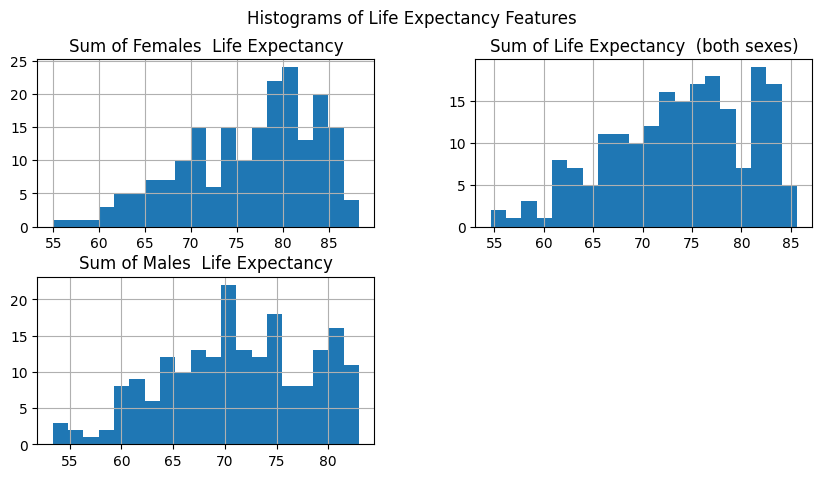

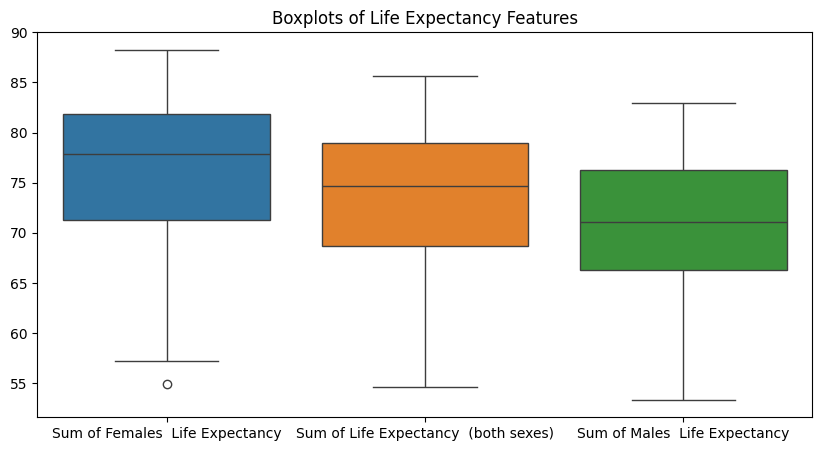

In [13]:
X.hist(bins=20, figsize=(10,5))
plt.suptitle("Histograms of Life Expectancy Features")

plt.figure(figsize=(10,5))
sns.boxplot(data=X)
plt.title("Boxplots of Life Expectancy Features");

Boxplotista havaitaan outlier, mutta kerta se on hyvin pienen matkan päässä vaihteluvälin alapäästä jätetään se sinne.

##### Correlation matrix

K-means-klusterointi perustuu etäisyyksiin ominaisuusavaruudessa, joten on tärkeää ymmärtää, kuinka vahvasti muuttujat ovat yhteydessä toisiinsa. Laskimme korrelaatiomatriisin elinajan odotuksen muuttujille:

In [14]:
corr_matrix = X.corr()
print("\n=== Correlation matrix ===")
print(corr_matrix)


=== Correlation matrix ===
                                      Sum of Females  Life Expectancy  \
Sum of Females  Life Expectancy                              1.000000   
Sum of Life Expectancy  (both sexes)                         0.991954   
Sum of Males  Life Expectancy                                0.966727   

                                      Sum of Life Expectancy  (both sexes)  \
Sum of Females  Life Expectancy                                   0.991954   
Sum of Life Expectancy  (both sexes)                              1.000000   
Sum of Males  Life Expectancy                                     0.991104   

                                      Sum of Males  Life Expectancy  
Sum of Females  Life Expectancy                            0.966727  
Sum of Life Expectancy  (both sexes)                       0.991104  
Sum of Males  Life Expectancy                              1.000000  


Tulokset osoittavat, että kaikki kolme muuttujaa ovat vahvasti positiivisesti korreloituneita:

    Naisten ja molempien sukupuolten elinajan odotuksen korrelaatio on erityisen korkea (~0.992).

    Miesten elinajan odotus korreloi myös vahvasti molempien sukupuolten ja naisten elinajan odotukseen (~0.967-0.991).

Tämä tarkoittaa, että maat, joissa naisten elinajan odotus on korkea, ovat tyypillisesti myös miesten ja molempien sukupuolten elinajan odotuksen osalta korkeita.

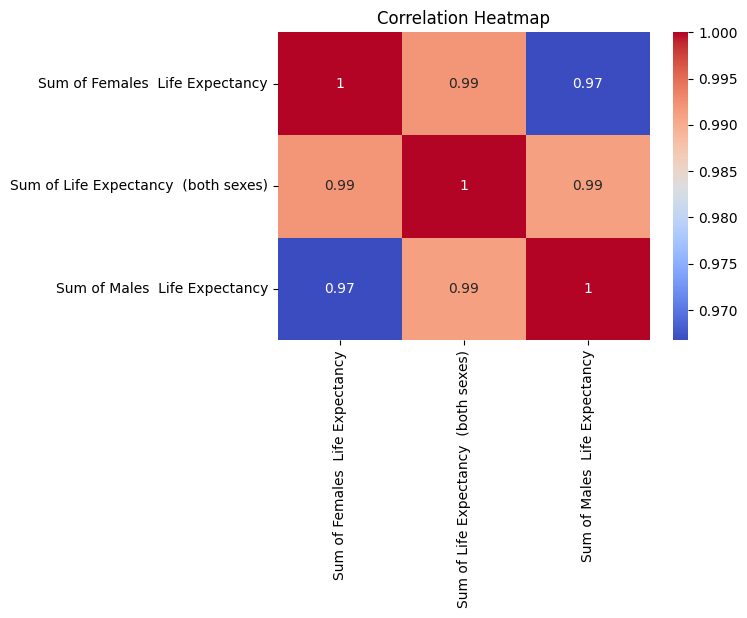

In [15]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap");


Johtopäätös: Datasetti sisältää vahvasti korreloivia, numeerisia muuttujia, mikä tekee siitä soveltuvan K-means-klusterointiin ja helpottaa ryhmittelyä matala-, keski- ja korkeaeliniän odotuksen maaryhmiin.

##### Inspecting the data

K-means-klusterointi perustuu Euclidean-etäisyyksiin, joten on tärkeää, että kaikki ominaisuudet ovat samalla mittakaavalla.

Ennen skaalausta datasetin ominaisuuksien jakaumat olivat seuraavat:

In [16]:
print(X.describe().loc[['mean','std','min','max']])

      Sum of Females  Life Expectancy  Sum of Life Expectancy  (both sexes)  \
mean                        76.412864                             73.786231   
std                          7.180037                              7.040573   
min                         54.940000                             54.640000   
max                         88.260000                             85.630000   

      Sum of Males  Life Expectancy  
mean                      71.184925  
std                        7.003951  
min                       53.360000  
max                       82.970000  


Ominaisuudet ovat saman mittaluokan lukuja, mutta pienet erot voivat silti vaikuttaa etäisyyksiin ja klusterikeskuksiin.

Esimerkiksi maksimit vaihtelevat noin 53-88 välillä.

Skaalasimme ominaisuudet standardoimalla ne (StandardScaler), jolloin jokaisen muuttujan keskiarvo on 0 ja keskihajonta 1:

In [17]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print(X_scaled_df.describe().loc[['mean','std','min','max']])

      Sum of Females  Life Expectancy  Sum of Life Expectancy  (both sexes)  \
mean                         0.000000                          1.428227e-16   
std                          1.002522                          1.002522e+00   
min                         -2.998177                         -2.726272e+00   
max                          1.654172                          1.686459e+00   

      Sum of Males  Life Expectancy  
mean                       0.000000  
std                        1.002522  
min                       -2.551400  
max                        1.686876  


Skaalauksen jälkeen kaikki muuttujat vaikuttavat tasapuolisesti klusteroinnissa.

Tämä varmistaa, ettei yksikään ominaisuus hallitse etäisyyksiä ja klusterien muodostusta.

Johtopäätös: Standardisointi on kriittinen vaihe, joka tekee datasetistä valmiin K-means-klusterointia varten ja mahdollistaa tasapuoliset havainnoiden väliset etäisyydet.

Ennen ja jälkeen skaalaus: havaintojen tarkastelu

On hyödyllistä tarkastella muutamia alkuperäisen ja skaalatun datasetin rivejä, jotta voidaan nähdä, miten standardisointi muuttaa arvot.

In [18]:
print("Original (first 5 rows):")
print(X.head())
print("\nScaled (first 5 rows):")
print(X_scaled_df.head())

Original (first 5 rows):
   Sum of Females  Life Expectancy  Sum of Life Expectancy  (both sexes)  \
0                            57.19                                 55.24   
1                            54.94                                 54.64   
2                            60.75                                 57.74   
3                            60.44                                 57.80   
4                            59.56                                 57.67   

   Sum of Males  Life Expectancy  
0                          53.36  
1                          54.33  
2                          54.76  
3                          55.03  
4                          55.51  

Scaled (first 5 rows):
   Sum of Females  Life Expectancy  Sum of Life Expectancy  (both sexes)  \
0                        -2.684018                             -2.640837   
1                        -2.998177                             -2.726272   
2                        -2.186948                      

    Sum of Females Life Expectancy

Alkuperäinen: 57.19

Skaalattu: -2.684

    Sum of Males Life Expectancy

Alkuperäinen: 53.36

Skaalattu: -2.551

    Sum of Life Expectancy (both sexes)

Alkuperäinen: 55.24

Skaalattu: -2.641

Ennen skaalausta arvot olivat reaalimaailman elinajan odotuksia, noin 54-88 vuotta.

Skaalauksen jälkeen arvot ovat standardisoituja, keskiarvo 0 ja keskihajonta 1.

Johtopäätös:

Standardisointi ei muuta havaintojen järjestystä tai suhteellisia eroja, mutta muuttaa niiden asteikon yhtenäiseksi, mikä on kriittistä K-means-klusteroinnin etäisyyslaskelmissa.

Tämä vaihe tekee datasetistä valmiin algoritmin syötteeksi.

## 1.2 First k-means run

Skaalauksen jälkeen sovellettiin K-means-klusterointia:

In [19]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=420)
kmeans.fit(X_scaled)

df_clean['Cluster'] = kmeans.labels_

Valitut parametrit:

n_clusters=3 - oletus, että maat jakautuvat matalan, keskitason ja korkean elinajanodotuksen ryhmiin.

n_init=10 - useampi alustus vähentää huonon satunnaisen alkuarvauksen riskiä.

random_state=420 - tulosten toistettavuus.

Algoritmi minimoi havaintojen ja klusterikeskusten välisen neliöidyn etäisyyden, jolloin maat ryhmittyvät mahdollisimman tiiviisiin elinajanodotusprofiileihin.

Klusterien jakauma

Seuraavaksi tarkasteltiin, kuinka monta maata sijoittui kuhunkin klusteriin:

In [20]:
print(df_clean['Cluster'].value_counts())

Cluster
2    76
0    70
1    53
Name: count, dtype: int64


Jakauma on kohtuullisen tasapainoinen: kaksi klusteria ovat lähes samankokoisia, ja pieninkin klusteri (53 havaintoa) on silti riittävän suuri ollakseen tulkittavissa ilman merkittävää vinoumaa.

Seuraavaksi katsotaan klusterikohtaisia keskiarvoja elinajan odotukselle:

In [21]:
print(df_clean.groupby('Cluster').mean(numeric_only=True))

         Sum of Females  Life Expectancy  \
Cluster                                    
0                              83.449143   
1                              66.651698   
2                              76.739211   

         Sum of Life Expectancy  (both sexes)  Sum of Males  Life Expectancy  
Cluster                                                                       
0                                   81.053571                      78.652429  
1                                   64.401887                      62.176792  
2                                   73.636974                      70.588947  


Keskiarvojen perusteella klusterit erottuvat selvästi:

Cluster 0 - korkea elinajanodotus (naiset, miehet ja molemmat).

Cluster 1 - matala elinajanodotus.

Cluster 2 - keskitasoinen elinajanodotus.

Ero näkyy kaikissa kolmessa muuttujassa, mikä kertoo klusteroinnin onnistuneesta rakenteesta.

Visualisointi PCA:n avulla

Kolmen ulottuvuuden data tiivistettiin kahteen pääkomponenttiin (PCA) visualisointia varten:

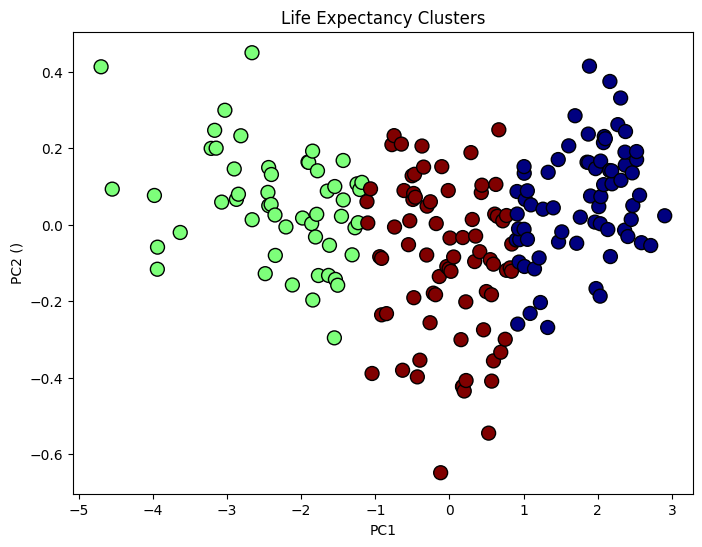

In [22]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=kmeans.labels_, cmap='jet', edgecolor='k', s=100)
plt.xlabel('PC1')
plt.ylabel('PC2 ()')
plt.title('Life Expectancy Clusters')
plt.show()

# PC1 ja PC2 koostuu pääosin skaalatuista elinajanodotuksista
# PC1 pääosin kokonais- ja naisten elinajan odotuksesta, -5 → 3
# PC2 pääosin miesten elinajan odotuksesta, -0.6 → 0.4

PCA säilyttää suurimman osan vaihtelusta ja tekee klusterijaon visuaalisesti tulkittavaksi.

Tulkinta:

klusterit muodostavat selvästi erillisiä alueita PCA-avaruudessa. Pisteiden väliset etäisyydet heijastavat elinajanodotusten eroja, ja mahdolliset lievät päällekkäisyydet sijoittuvat raja-arvojen maille.

Johtopäätös:

Ensimmäinen K-means-ajokerta tuottaa selkeät, tulkittavat klusterit, jotka kuvaavat matalan, keskitasoisen ja korkean elinajanodotuksen maaryhmiä.
Tämä toimii perustana seuraaville vaiheille: erilaiset k-arvot, Elbow-metodi ja vaihtoehtoiset parametrikokeilut.

## 1.3 Listing of 2 more interresting use cases for k-means algorithm

## 2.1 Experiments with different values of $k$

Tavoitteena oli arvioida, miten klusterien määrä vaikuttaa ryhmittelyn rakenteeseen ja havaintojen samankaltaisuuksiin. Testatut arvot olivat k = 2, 3, 4 ja 5. Jokaiselle arvolle suoritettiin erillinen K-means-klusterointi (n_init=10, random_state=420), ja klusterikohtaiset keskiarvot tallennettiin vertailua varten.

Seuraavaksi suoritettiin K-means-klusterointi useilla k-arvoilla ja tallennettiin klusterikohtaiset keskiarvot analyysiä varten:

In [23]:
k_values = [2, 3, 4, 5]
cluster_summaries = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=420)
    kmeans.fit(X_scaled)

    df_clean['Cluster'] = kmeans.labels_
    
    cluster_summaries[k] = df_clean.groupby('Cluster').mean(numeric_only=True)

Selitys:

Jokaiselle k-arvolle suoritetaan erillinen K-means-klusterointi.

df_clean['Cluster'] päivittyy väliaikaisesti klusteritunnisteilla analyysiä varten.

cluster_summaries[k] sisältää kunkin klusterin keskiarvot kaikille numeerisille muuttujille, mm.:

Sum of Females Life Expectancy

Sum of Life Expectancy (both sexes)

Sum of Males Life Expectancy

Tarkoitus:

Tämä mahdollistaa systemaattisen vertailun eri klusterimäärien välillä.

Voidaan tarkastella, miten klusterien profiilit muuttuvat k=2,3,4,5 ja arvioida, mikä k kuvaa parhaiten datasetin eroja.

Klusterien keskiarvot eri k-arvoilla

Seuraavaksi tarkasteltiin klusterikohtaisia keskiarvoja eri k-arvoilla:

In [24]:
for k in k_values:
    print(f"\n--- k = {k} ---")
    print(cluster_summaries[k])


--- k = 2 ---
         Sum of Females  Life Expectancy  \
Cluster                                    
0                              69.305904   
1                              81.498017   

         Sum of Life Expectancy  (both sexes)  Sum of Males  Life Expectancy  
Cluster                                                                       
0                                   66.865181                      64.474337  
1                                   78.738362                      75.986466  

--- k = 3 ---
         Sum of Females  Life Expectancy  \
Cluster                                    
0                              83.449143   
1                              66.651698   
2                              76.739211   

         Sum of Life Expectancy  (both sexes)  Sum of Males  Life Expectancy  
Cluster                                                                       
0                                   81.053571                      78.652429  
1                  

    k = 2

Ryhmä jakautuu matalan ja korkean eliniän odotuksen maihin. Keskiarvot eroavat selvästi, ja PCA:ssa ryhmät muodostavat kaksi selkeää aluetta.

Tulkinta:
Hyvin karkea jako. Ei pysty erottamaan keskitason maita lainkaan, jolloin informaatiosisältö on rajallinen.

    k = 3

Muodostuu kolme selkeää ryhmää: matala-, keski- ja korkean eliniän maat. Klusterikoot pysyvät tasapainossa, ja keskiarvoissa on selviä tasoeroja kaikilla muuttujilla. PCA:ssa klusterit erottuvat toisistaan ilman päällekkäisyyksiä.

Tulkinta:
Tämä on ensimmäinen arvo, jossa data muodostaa luonnollisia ryhmiä ilman, että klusterit hajoavat liian pieniksi. Erottelu on selkeä sekä numeerisesti että PCA:ssa.

    k = 4

Korkean eliniän klusteri hajoaa kahteen pienempään ryhmään, joiden erot ovat vähäisiä. Matalaeliniän klusteri säilyy selkeänä, mutta lisääntynyt granulaatio ei tuo olennaista uutta informaatiosisältöä.

Tulkinta:
k = 4 tuo lisää segmentointia, mutta uudet klusterit eivät muodosta olennaisesti uusia, tulkittavia ”elämäntilaryhmiä”. Jakautuminen alkaa olla enemmän teknistä kuin informatiivista.

    k = 5

Useat klusterit pienenevät selvästi, osa sisältää vain pienen joukon maita. Erottelut muuttuvat marginaalisiksi, ja PCA:ssa klusterit alkavat limittyä.

Tulkinta:
Ylisegmentointi. Malli tunnistaa pieniä variaatioita, mutta ne eivät muodosta selittäviä tai luontevia ryhmiä.

Johtopäätös:

Eri k-arvojen vertailu osoittaa, että k = 3 tuottaa tasapainoisimmat ja informatiivisimmat klusterit. Kaksi klusteria on liian yksinkertainen rakenne, ja suuremmat k-arvot pilkkovat dataa pieniin, tulkinnallisesti heikkoihin ryhmiin. Kolmen klusterin malli vastaa parhaiten datasetin todellisia elinajan odotuksen tasoeroja.

Klusterien visualisointi eri k-arvoilla (PCA 2D)

Visualisointi miten klusterit jakautuvat kahteen pääkomponenttiin (PCA) eri k-arvoilla:

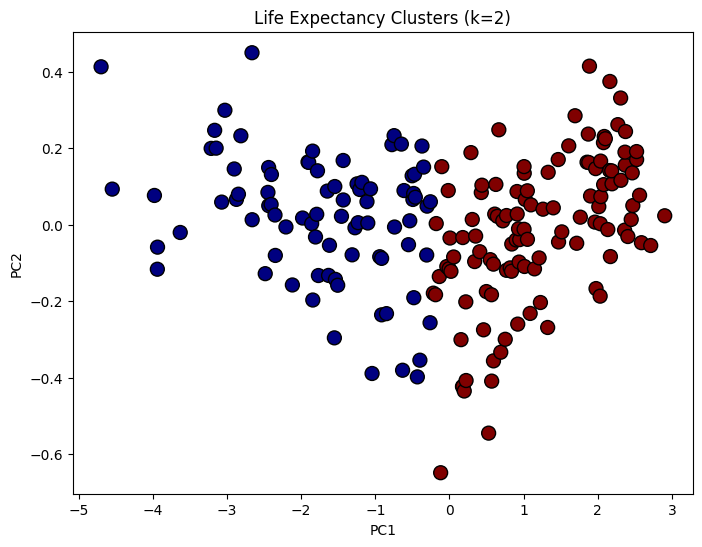

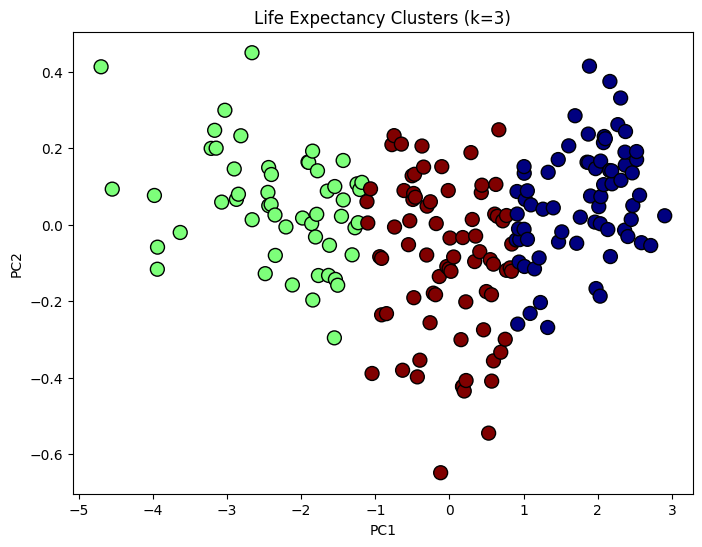

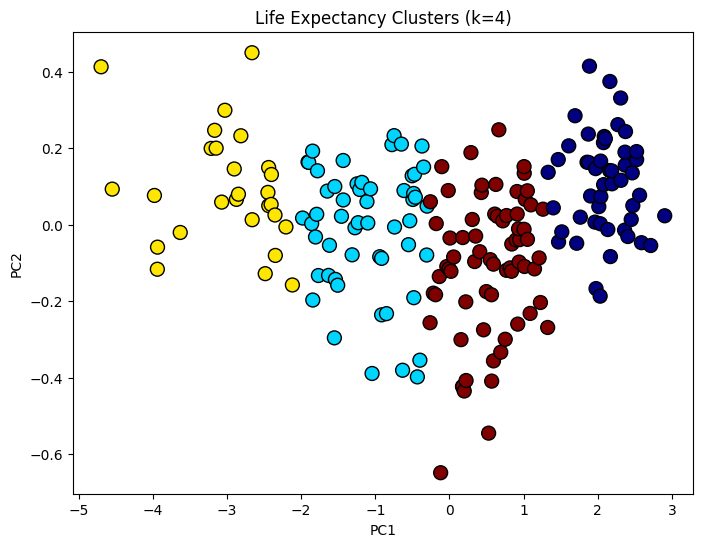

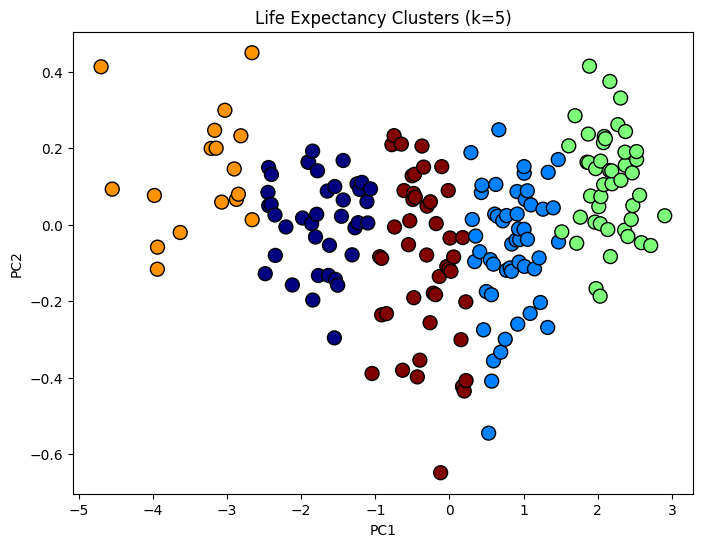

In [25]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=420)
    kmeans.fit(X_scaled)
    
    plt.figure(figsize=(8,6))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=kmeans.labels_, cmap='jet', edgecolor='k', s=100)
    plt.title(f'Life Expectancy Clusters (k={k})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

## 2.2 Utilization for Elbow method

Elbow-menetelmän tavoitteena on arvioida, kuinka monta klusteria on perusteltua muodostaa ilman ylisegmentointia. Menetelmä perustuu inertia-arvoon, joka kuvaa havaintojen etäisyyksien neliösummaa omista klusterikeskuksistaan. Arvo pienenee aina k:n kasvaessa, mutta ei lineaarisesti ja juuri murroskohta (“kyynärpää”) on olennainen.

Elbow-menetelmä

Testattiin arvot k = 1-10, ja laskettiin inertia jokaiselle:

inertia pienenee nopeasti, jos uusi klusteri selittää merkittävän rakenteen datassa

pienenee hitaasti, jos lisäklusterit eivät enää tuo olennaista uutta rakennetta

Näin voidaan tunnistaa kohta, jossa parannus hidastuu selvästi.

In [26]:
k_range = range(1, 11)
inertia_values = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

Elbow-menetelmän visualisointi

Elbow-käyrä näyttää tyypillisen nopeasti laskevan alun ja sen jälkeen tasaantuvan muodon. jyrkin lasku tapahtuu välillä k=1 -> k=3.

k=1 -> k=2: suuri parannus, koska data jaetaan ensimmäistä kertaa

k=2 -> k=3: edelleen selvä lisäparannus

k>3: inertia pienenee enää marginaalisesti

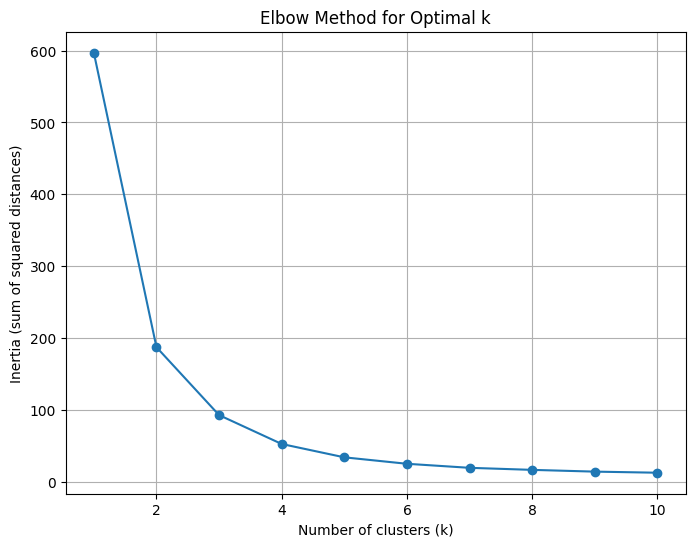

In [27]:
plt.figure(figsize=(8,6))
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Tulkinta:

Käyrään muodostuu selkeä “kyynärpää” kohdalle:

k ~ 3

Tämän jälkeen käyrä siirtyy lähes lineaariseen, loivaan laskuun, mikä tarkoittaa, että lisäklusterit eivät enää tiivistä klustereita merkittävästi.

Tulkinta on linjassa aiemmin havaittujen klusterikeskiarvojen ja PCA-visualisoinnin kanssa: kolmen klusterin malli kuvaa datan rakenteen olennaiset tasoerot ilman tarpeetonta monimutkaisuutta.

Johtopäätös:

Elbow-menetelmä osoittaa, että k=3 on optimaalinen valinta:

tuottaa merkittävän inertia-parannuksen

säilyttää klusterit riittävän suurina ja tulkittavina

estää ylisegmentoinnin, joka näkyy k>3 tapauksissa

Menetelmä vahvistaa systemaattisesti, että kolmen klusterin rakenne on datalle sekä rakenteellisesti että tulkinnallisesti paras.

## 2.3 Testing various options for the k-means algorithm (See the sklean documentation for k-means)

K-meansin käyttäytymistä testattiin muuttamalla seuraavia parametrejä:

init (keskipisteiden alustus),

max_iter (suurin sallittu iterointimäärä),

algorithm (Lloyd vs. Elkan).

Kaikissa testeissä käytettiin k=3, koska edelliset osat osoittivat tämän olevan datalle järkevin klusterimäärä.

### Run 1: Different initialization methods

    Testatut menetelmät:

k-means++

random

    Tulokset olivat identtiset:

inertia sama molemmilla (~ 92.56)

klusterien koot samat (76 / 70 / 53; vain label-järjestys vaihtuu)

In [28]:
for init_method in ['k-means++', 'random']:
    kmeans_init = KMeans(n_clusters=3, init=init_method, n_init=10, random_state=420)
    kmeans_init.fit(X_scaled)
    print(f"Init method: {init_method}")
    print(f"Inertia: {kmeans_init.inertia_}")
    print(f"Cluster counts:\n{pd.Series(kmeans_init.labels_).value_counts()}\n")

Init method: k-means++
Inertia: 92.5576380923723
Cluster counts:
2    76
0    70
1    53
Name: count, dtype: int64

Init method: random
Inertia: 92.5576380923723
Cluster counts:
0    76
1    70
2    53
Name: count, dtype: int64



    Tulkinta:

Aloitusmenetelmällä ei ole käytännön vaikutusta tähän datasettiin.
Data on yksinkertainen ja rakenteeltaan selkeä, jolloin algoritmi löytää samat klusterit riippumatta aloituksesta.

    Johtopäätös:
init-valinta ei muuta klusterointia, mutta k-means++ on suositeltava yleisesti nopeamman ja vakaamman konvergenssin vuoksi.

### Run 2: Different maximum iterations

Testatut arvot: 1, 2, 3, 4, 5, 10, 100

Havainnot

max_iter = 1-3: inertia-arvot epävakaita (94.5 -> 92.7), klusterien koot heittelevät voimakkaasti.
Tällöin algoritmi ei ehdi konvergoida.

max_iter = 4-5: inertia vakautuu ~ 92.61; klusterien jakauma normalisoituu.

max_iter = 10 ja 100:
inertia pysyy identtisenä (~ 92.60), klusterijakauma sama.
tällöin konvergenssi on saavutettu jo ennen 10 iteraatiota.

Mikäli random_state = 420, Tällöin Inertia iteraatioilla 1-2 on 92.63. 3-5,10,100 iteraatiolla inertia on kaikilla 92.56, random_state = 420 on liian maaginen.

In [29]:
for max_it in [1,2,3,4,5,10,100]:
    kmeans_iter = KMeans(n_clusters=3, max_iter=max_it, n_init=10, random_state=42)
    kmeans_iter.fit(X_scaled)
    print(f"Max iterations: {max_it}")
    print(f"Inertia: {kmeans_iter.inertia_}")
    print(f"Cluster counts:\n{pd.Series(kmeans_iter.labels_).value_counts()}\n")

Max iterations: 1
Inertia: 94.50256987691239
Cluster counts:
1    90
2    56
0    53
Name: count, dtype: int64

Max iterations: 2
Inertia: 92.92549920145126
Cluster counts:
1    87
2    57
0    55
Name: count, dtype: int64

Max iterations: 3
Inertia: 92.70224823356992
Cluster counts:
0    88
1    57
2    54
Name: count, dtype: int64

Max iterations: 4
Inertia: 92.60952106077647
Cluster counts:
2    88
0    57
1    54
Name: count, dtype: int64

Max iterations: 5
Inertia: 92.60952106077647
Cluster counts:
2    88
1    57
0    54
Name: count, dtype: int64

Max iterations: 10
Inertia: 92.60363329037581
Cluster counts:
1    88
0    56
2    55
Name: count, dtype: int64

Max iterations: 100
Inertia: 92.60363329037581
Cluster counts:
1    88
0    56
2    55
Name: count, dtype: int64



    Tulkinta:

Liian pieni max_iter tuottaa selvästi virheellisiä klustereita.
Muutaman iteraation jälkeen tulos ei enää muutu käytännössä lainkaan.

    Johtopäätös:

max_iter = 10 riittää täysin.
Liian suuret arvot lisäävät vain laskentakustannusta ilman hyötyä.

### Run 3: Different algorithms

    Testatut algoritmit:

lloyd

elkan

    Havainnot:

inertia identtinen molemmilla (~ 92.56)

klusterien koot identtiset

label-jakaumat 0 = 70 / 1 = 53 / 2 = 76 molemmissa

In [30]:
for algo in ['lloyd', 'elkan']:
    kmeans_algo = KMeans(n_clusters=3, algorithm=algo, n_init=10, random_state=420)
    kmeans_algo.fit(X_scaled)
    print(f"Algorithm: {algo}")
    print(f"Inertia: {kmeans_algo.inertia_}")
    print(f"Cluster counts:\n{pd.Series(kmeans_algo.labels_).value_counts()}\n")

Algorithm: lloyd
Inertia: 92.5576380923723
Cluster counts:
2    76
0    70
1    53
Name: count, dtype: int64

Algorithm: elkan
Inertia: 92.5576380923723
Cluster counts:
2    76
0    70
1    53
Name: count, dtype: int64



    Tulkinta:

Datasetti on pieni ja mataladimensionaalinen, jolloin Elkanin optimoinnit eivät tuota näkyvää eroa.
Klusterit ja niiden sijoittelu pysyivät täsmälleen samoina.

    Johtopäätös:

algorithm-parametri ei vaikuta tulokseen tässä aineistossa, mutta
Elkan voi tuoda merkittävän nopeusedun suuremmissa ja moniulotteisemmissa dataseteissä.

Lopputulos:

Testatut hyperparametrit osoittavat:

init ei vaikuta klusterointiin

max_iter vaikuttaa selvästi vain, jos arvo on liian pieni niin saadaan epävakaa tulos

algorithm ei muuta lopputulosta, koska data on pieni ja selkeä

Kokonaisuutena K-means toimii tässä datassa erittäin deterministisesti, kunhan iterointimäärä on riittävä. Tämä korostaa, että tulokset heijastavat datasetin todellista rakennetta, eivät algoritmin satunnaisuutta tai asetuksia.